## 1  Load Data

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
# Paths to your files
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

# First attempt with folder ID
path1_10_present = 'foia-504-fy2010-present-asof-240930.csv'
path1_91_09 = 'foia-504-fy1991-fy2009-asof-240930.csv'

# Second attempt with folder name
path2_10_present = '/content/drive/My Drive/MS&E246/10_present.csv'
path2_91_09 = '/content/drive/My Drive/MS&E246/91_09.csv'

# Try reading with both paths
try:
    # Try first path
    df_10_present = pd.read_csv(path1_10_present)
    df_91_09 = pd.read_csv(path1_91_09)
    print("Successfully read from folder ID path")
except:
    try:
        # Try second path
        df_10_present = pd.read_csv(path2_10_present)
        df_91_09 = pd.read_csv(path2_91_09)
        print("Successfully read from folder name path")
    except Exception as e:
        print(f"Error: {e}")

C:\Users\caixu\AppData\Local\Temp\ipykernel_11064\2673779660.py:19: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_10_present = pd.read_csv(path1_10_present)


Successfully read from folder ID path


C:\Users\caixu\AppData\Local\Temp\ipykernel_11064\2673779660.py:20: DtypeWarning: Columns (12,13,14,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_91_09 = pd.read_csv(path1_91_09)


In [2]:
#What is the id of the dataset
id_columns = ['AsOfDate', 'Program', 'BorrName', 'BorrStreet', 'BorrCity', 'BorrState', 'BorrZip']

# Check for 10_present dataset
duplicates_10 = df_10_present.groupby(id_columns).size().reset_index(name='count')
has_duplicates_10 = any(duplicates_10['count'] > 1)

# Check for 91_09 dataset
duplicates_91 = df_91_09.groupby(id_columns).size().reset_index(name='count')
has_duplicates_91 = any(duplicates_91['count'] > 1)

print("Duplicates in 10_present:", has_duplicates_10)
print("Duplicates in 91_09:", has_duplicates_91)

# If there are duplicates, let's see some examples
if has_duplicates_10:
    print("\nExample duplicates in 10_present:")
    print(duplicates_10[duplicates_10['count'] > 1].head())

if has_duplicates_91:
    print("\nExample duplicates in 91_09:")
    print(duplicates_91[duplicates_91['count'] > 1].head())

Duplicates in 10_present: True
Duplicates in 91_09: True

Example duplicates in 10_present:
      AsOfDate  Program                   BorrName                BorrStreet  \
80   9/30/2024      504       1013 Enterprises LLC      1013 Lincoln Highway   
150  9/30/2024      504  10820 Hemlock Avenue, LLC      10820 Hemlock Avenue   
195  9/30/2024      504    1128 Petro Parkway, LLC    1128 Petroleum Parkway   
308  9/30/2024      504           123 Western, LLC  123 North Western Avenue   
528  9/30/2024      504                  1508, LLC  1508 Kaliste Saloom Road   

         BorrCity BorrState  BorrZip  count  
80   Schererville        IN    46375      2  
150       Fontana        CA    92337      2  
195     Broussard        LA    70518      2  
308       Chicago        IL    60612      2  
528     Lafayette        LA    70508      2  

Example duplicates in 91_09:
      AsOfDate  Program                        BorrName  \
236  9/30/2024      504               220PROPERTIES LLC   
248

## 2  Preliminary Cleaning

In [3]:
df_all = pd.concat([df_91_09, df_10_present])

In [4]:
def preliminary_clean_loan_data(df):
    # Make a copy to avoid modifying original data
    df_clean = df.copy()

    print("Initial size:", len(df_clean))

    # 1. Clean Loan Status
    if 'Status' in df_clean.columns:
        status_col = 'Status'
    elif 'LoanStatus' in df_clean.columns:
        status_col = 'LoanStatus'

    # Print unique statuses before cleaning
    print("\nUnique loan statuses before cleaning:")
    print(df_clean[status_col].value_counts())

    # Remove canceled and not funded loans but keep CHGOFF with zero charge-off
    canceled_mask = df_clean[status_col].str.contains('CANCLD|CANCEL|Canceled|NOT FUNDED', na=False, case=False)
    df_clean = df_clean[~canceled_mask]

    # 2. Check monetary values
    monetary_cols = ['GrossApproval', 'ThirdPartyDollars', 'GrossChargeOffAmount']
    for col in monetary_cols:
        if col in df_clean.columns:
            # Remove negative values
            df_clean = df_clean[df_clean[col].fillna(0) >= 0]

    # 3. Check dates
    date_cols = ['AsOfDate', 'ApprovalDate', 'PaidInFullDate']

    for col in date_cols:
        if col in df_clean.columns:
            # Convert to datetime
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

            # Remove future dates (except AsOfDate which might be a reporting date)
            if col != 'AsOfDate':
                df_clean = df_clean[
                    (df_clean[col].isna()) |
                    (df_clean[col] <= pd.Timestamp.now())
                ]

    # 4. Check logical consistency
    # PaidInFullDate should be after ApprovalDate
    if 'PaidInFullDate' in df_clean.columns and 'ApprovalDate' in df_clean.columns:
        df_clean = df_clean[
            ~((df_clean['PaidInFullDate'].notna()) &
              (df_clean['PaidInFullDate'] < df_clean['ApprovalDate']))
        ]

    # 5. Remove rows with missing crucial information
    crucial_cols = ['BorrName', 'GrossApproval', status_col]
    df_clean = df_clean.dropna(subset=crucial_cols)

    print("\nFinal size after cleaning:", len(df_clean))
    print("\nUnique loan statuses after cleaning:")
    print(df_clean[status_col].value_counts())

    return df_clean

# Clean both datasets
df_clean = preliminary_clean_loan_data(df_all)

Initial size: 218095

Unique loan statuses before cleaning:
LoanStatus
PIF           107245
EXEMPT         59555
CANCLD         30641
CHGOFF         12078
NOT FUNDED      8226
Name: count, dtype: int64

Final size after cleaning: 178877

Unique loan statuses after cleaning:
LoanStatus
PIF       107244
EXEMPT     59555
CHGOFF     12078
Name: count, dtype: int64


## 3  Train/Test Split

In [5]:
CUTOFF = "2011-01-01"

### 3.1 Process loans with approval date before CUTOFF as training set:

In [6]:
## 3.1.1 Loans that have approval date before CUTOFF and are in EXEMPT state

df_before_and_exempt = df_clean[(df_clean["ApprovalDate"] < CUTOFF) & (df_clean["LoanStatus"] == "EXEMPT")]
# Not default
df_before_and_exempt["Default"] = False
# Survival time is (CUTOFF - approval date)
df_before_and_exempt["SurvivalDays"] = (datetime.strptime(CUTOFF, '%Y-%m-%d') - df_before_and_exempt["ApprovalDate"]).dt.days
# Loss at default is 0
df_before_and_exempt["LossAtDefault"] = 0

In [7]:
## 3.1.2 Loans that have approval date before CUTOFF and are in PIF state

# 3.1.2(a) PaidInFullDate before CUTOFF: treat as paid at maturity
df_before_and_pif_1 = df_clean[(df_clean["ApprovalDate"] < CUTOFF) & (df_clean["LoanStatus"] == "PIF") & (df_clean["PaidInFullDate"] <= CUTOFF)]
# Not default
df_before_and_pif_1["Default"] = False
# Survival time is the term
df_before_and_pif_1["SurvivalDays"] = df_before_and_pif_1["TermInMonths"] * 30
# Loss at default is 0
df_before_and_pif_1["LossAtDefault"] = 0

# 3.1.2(b) PaidInFullDate after CUTOFF: treat as EXEMPT
df_before_and_pif_2 = df_clean[(df_clean["ApprovalDate"] < CUTOFF) & (df_clean["LoanStatus"] == "PIF") & (df_clean["PaidInFullDate"] > CUTOFF)]
# Not default
df_before_and_pif_2["Default"] = False
# Survival time is (CUTOFF - approval date)
df_before_and_pif_2["SurvivalDays"] = (datetime.strptime(CUTOFF, '%Y-%m-%d') - df_before_and_pif_2["ApprovalDate"]).dt.days
# Loss at default is 0
df_before_and_pif_2["LossAtDefault"] = 0

In [8]:
## 3.1.3 Loans that have approval date before CUTOFF and are in CHGOFF state

df_before_and_chgoff = df_clean[(df_clean["ApprovalDate"] < CUTOFF) & (df_clean["LoanStatus"] == "CHGOFF")]
df_before_and_chgoff["ChargeOffDate"] = df_before_and_chgoff["ChargeOffDate"].apply(pd.to_timedelta,unit = 'D') + datetime.strptime("1900-01-01", '%Y-%m-%d')
# Default is true
df_before_and_chgoff["Default"] = True
# Survival time is (charge off date - approval date)
df_before_and_chgoff["SurvivalDays"] = (df_before_and_chgoff["ChargeOffDate"] - df_before_and_chgoff["ApprovalDate"]).dt.days
# Loss at default is gross charge off amount
df_before_and_chgoff["LossAtDefault"] = df_before_and_chgoff["GrossChargeOffAmount"]

In [9]:
df_train = pd.concat([df_before_and_exempt, df_before_and_pif_1, df_before_and_pif_2, df_before_and_chgoff])
print("Size of training set:", len(df_train))

Size of training set: 101703


C:\Users\caixu\AppData\Local\Temp\ipykernel_11064\3210809056.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_train = pd.concat([df_before_and_exempt, df_before_and_pif_1, df_before_and_pif_2, df_before_and_chgoff])


### 3.2 Process loans with approval date after CUTOFF as testing set:

In [10]:
# ## 3.2.1 Loans that have approval date after CUTOFF and are in EXEMPT state

# df_after_and_exempt = df_clean[(df_clean["ApprovalDate"] >= CUTOFF) & (df_clean["LoanStatus"] == "EXEMPT")]
# # Not default
# df_after_and_exempt["Default"] = False
# # Survival time is (as of date - approval date)
# df_after_and_exempt["SurvivalDays"] = (df_after_and_exempt["AsOfDate"] - df_after_and_exempt["ApprovalDate"]).dt.days
# # Loss at default is 0
# df_after_and_exempt["LossAtDefault"] = 0

In [11]:
## 3.2.2 Loans that have approval date after CUTOFF and are in PIF state: all treat as paid at maturity
df_after_and_pif = df_clean[(df_clean["ApprovalDate"] >= CUTOFF) & (df_clean["LoanStatus"] == "PIF")]
# Not default
df_after_and_pif["Default"] = False
# Survival time is the term
df_after_and_pif["SurvivalDays"] = df_after_and_pif["TermInMonths"] * 30
# Loss at default is 0
df_after_and_pif["LossAtDefault"] = 0

In [12]:
## 3.2.3 Loans that have approval date after CUTOFF and are in CHGOFF state

df_after_and_chgoff = df_clean[(df_clean["ApprovalDate"] >= CUTOFF) & (df_clean["LoanStatus"] == "CHGOFF")]
df_after_and_chgoff["ChargeOffDate"] = df_after_and_chgoff["ChargeOffDate"].apply(pd.to_timedelta,unit = 'D') + datetime.strptime("1900-01-01", '%Y-%m-%d')
# Default is true
df_after_and_chgoff["Default"] = True
# Survival time is (charge off date - approval date)
df_after_and_chgoff["SurvivalDays"] = (df_after_and_chgoff["ChargeOffDate"] - df_after_and_chgoff["ApprovalDate"]).dt.days
# Loss at default is gross charge off amount
df_after_and_chgoff["LossAtDefault"] = df_after_and_chgoff["GrossChargeOffAmount"]

In [13]:
df_test = pd.concat([df_after_and_pif, df_after_and_chgoff])
print("Size of testing set:", len(df_test))

Size of testing set: 25619


C:\Users\caixu\AppData\Local\Temp\ipykernel_11064\1409581260.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_after_and_pif, df_after_and_chgoff])


## 4  Data Exploration: Test of Feature Relevance

In [14]:
df_train["NaicsCodeBigCategory"] = df_train["NaicsCode"].apply(lambda x: str(x)[:2])
df_train["JS20"] = df_train["JobsSupported"]>20

In [15]:
from scipy.stats import chi2_contingency

candidates = ["BorrState", "DeliveryMethod", "Subprogram", "NaicsCodeBigCategory", "ProjectState", "BusinessType", "JS20"]
chi2s = []
pvalues = []

for col in candidates:
    df_train_not_na = df_train[~df_train[col].isna()]
    cross_tab = pd.crosstab(df_train_not_na[col], df_train_not_na["Default"])
    chi2_results = chi2_contingency(cross_tab)
    chi2s.append(float(chi2_results.statistic))
    pvalues.append(float(chi2_results.pvalue))

candidates.append("ThirdPartyLender_Name_FirstLetterUpper")
df_train_not_na = df_train[~df_train["ThirdPartyLender_Name"].isna()]
cross_tab = pd.crosstab(df_train_not_na["ThirdPartyLender_Name"].apply(lambda x:x[0].isupper()), df_train_not_na["Default"])
chi2_results = chi2_contingency(cross_tab)
chi2s.append(float(chi2_results.statistic))
pvalues.append(float(chi2_results.pvalue))

result = pd.DataFrame({"Candidate Feature":candidates, "Chi2":chi2s, "p-value":pvalues}).sort_values(by='p-value')
result

,Candidate Feature,Chi2,p-value
0,BorrState,1688.900321,0.000000e+00
3,NaicsCodeBigCategory,3194.004011,0.000000e+00
4,ProjectState,1672.304421,0.000000e+00
1,DeliveryMethod,102.850191,3.789397e-22
5,BusinessType,60.534337,7.163672e-14
2,Subprogram,38.005504,5.587400e-09
7,ThirdPartyLender_Name_FirstLetterUpper,0.752949,3.855442e-01
6,JS20,0.136509,7.117764e-01


## 5  Kaplan Meier Curve of Overall Survival

In [16]:
from lifelines import KaplanMeierFitter

Text(0.5, 1.0, 'Overall Survival')

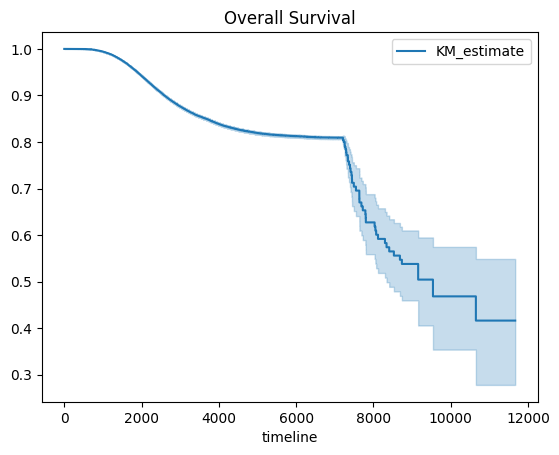

In [17]:
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
kmf.fit(durations = df_train["SurvivalDays"], event_observed = df_train["Default"])
kmf.plot_survival_function()
plt.title("Overall Survival")

Text(0.5, 1.0, 'Survival of different Naics Big Category group')

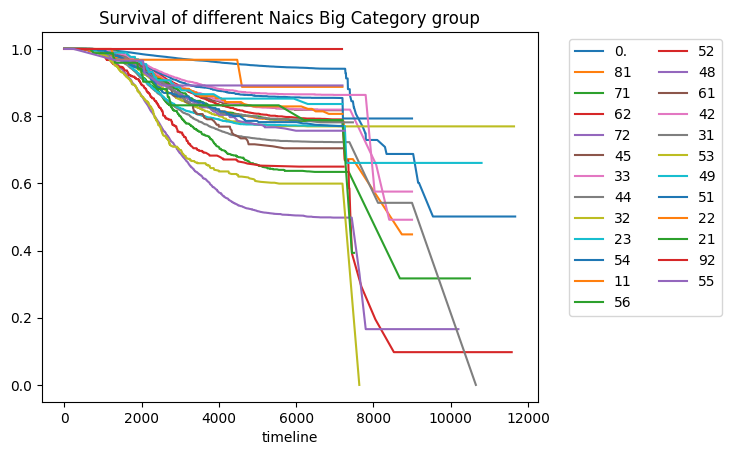

In [18]:
import matplotlib.pyplot as plt

naics_big_cat = df_train["NaicsCode"].apply(lambda x: str(x)[:2])
cat_list = list(naics_big_cat.unique())

ax = plt.subplot(111)
for c in cat_list:
    m = (naics_big_cat == c)
    kmf.fit(durations = df_train["SurvivalDays"][m], event_observed = df_train["Default"][m], label = c)
    kmf.survival_function_.plot(ax = ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.title("Survival of different Naics Big Category group")

Text(0.5, 1.0, 'Survival of different Borrower State group')

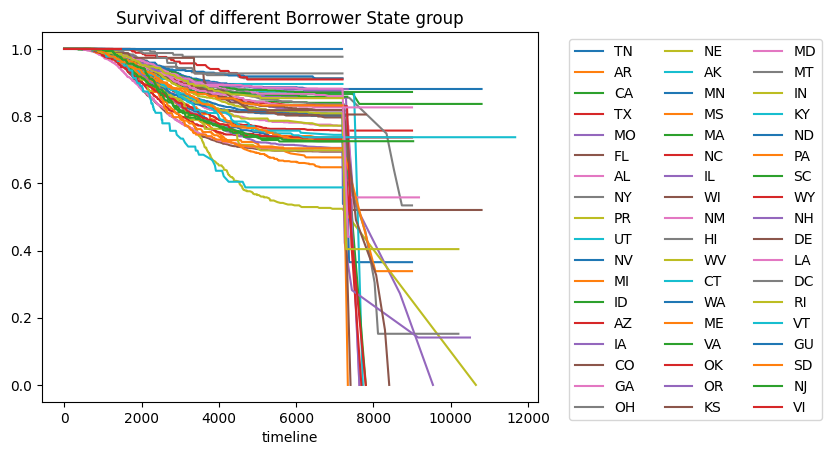

In [19]:
cat_list = list(df_train["BorrState"].unique())

ax = plt.subplot(111)
for c in cat_list:
    m = (df_train["BorrState"] == c)
    kmf.fit(durations = df_train["SurvivalDays"][m], event_observed = df_train["Default"][m], label = c)
    kmf.survival_function_.plot(ax = ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)
plt.title("Survival of different Borrower State group")

Text(0.5, 1.0, 'Survival of different Project State group')

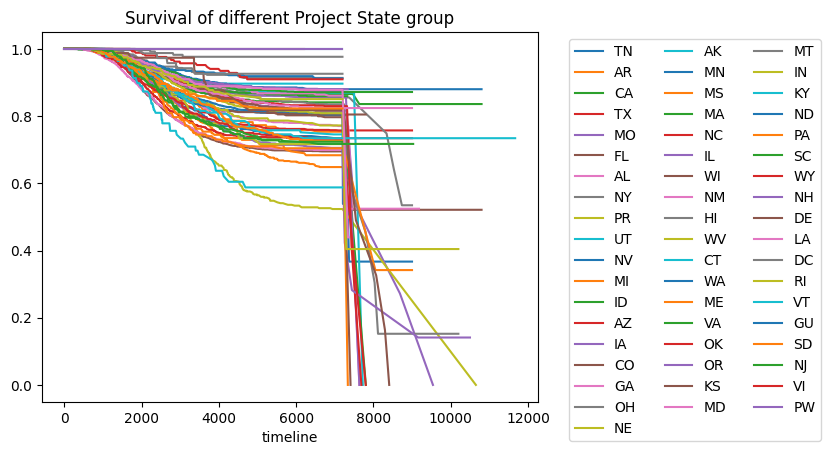

In [20]:
cat_list = list(df_train["ProjectState"][~df_train["ProjectState"].isna()].unique())

ax = plt.subplot(111)
for c in cat_list:
    m = (df_train["ProjectState"] == c)
    kmf.fit(durations = df_train["SurvivalDays"][m], event_observed = df_train["Default"][m], label = c)
    kmf.survival_function_.plot(ax = ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)
plt.title("Survival of different Project State group")

## 6  Hazard Model without Time Variables

In [21]:
df_train["20JobsSupported"] = df_train["JobsSupported"] >= 20

use_cols = ["GrossApproval", "DeliveryMethod", "Subprogram", "TermInMonths", "NaicsCodeBigCategory", "BusinessType", "20JobsSupported","BorrState","Default","SurvivalDays"]
cat_cols = ["DeliveryMethod", "Subprogram", "NaicsCodeBigCategory", "BusinessType","BorrState"]

df_raw = df_train[use_cols]
for cat in cat_cols:
    dummies = pd.get_dummies(df_train[cat], prefix = cat)
    df_raw = pd.concat([df_raw, dummies], axis = 1)
    df_raw = df_raw.drop(cat, axis = 1)

In [22]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.0001)
cph.fit(df_raw, duration_col = 'SurvivalDays', event_col = 'Default', show_progress=True)
cph.print_summary()

C:\Users\caixu\AppData\Local\Programs\Python\Python311\Lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['DeliveryMethod_Direct Loans', 'BorrState_VI'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Iteration 1: norm_delta = 1.47e+00, step_size = 0.9500, log_lik = -125430.57970, newton_decrement = 5.60e+03, seconds_since_start = 1.1
Iteration 2: norm_delta = 4.18e-01, step_size = 0.9500, log_lik = -121632.35870, newton_decrement = 1.08e+03, seconds_since_start = 2.3
Iteration 3: norm_delta = 7.22e-02, step_size = 0.9500, log_lik = -120515.72283, newton_decrement = 3.30e+01, seconds_since_start = 3.4
Iteration 4: norm_delta = 1.84e-02, step_size = 1.0000, log_lik = -120481.35601, newton_decrement = 2.41e-01, seconds_since_start = 4.5
Iteration 5: norm_delta = 1.42e-02, step_size = 1.0000, log_lik = -120481.09484, newton_decrement = 2.21e-02, seconds_since_start = 5.6
Iteration 6: norm_delta = 8.22e-03, step_size = 1.0000, log_lik = -120481.06819, newton_decrement = 3.88e-03, seconds_since_start = 6.7
Iteration 7: norm_delta = 2.46e-03, step_size = 1.0000, log_lik = -120481.06380, newton_decrement = 2.35e-04, seconds_since_start = 7.8
Iteration 8: norm_delta = 2.14e-04, step_size = 

<lifelines.CoxPHFitter: fitted with 101703 total observations, 90213 right-censored observations>
             duration col = 'SurvivalDays'
                event col = 'Default'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 101703
number of events observed = 11490
   partial log-likelihood = -120481.06
         time fit was run = 2025-02-21 00:52:43 UTC

---
                                                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                        
GrossApproval                                                    0.00      1.00      0.00            0.00            0.00                1.00                1.00
TermInMonths                                                    -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
20JobsSupported                                                 -0.43      0.65      0.02           -0.47           -0.38                0.62                0.68
DeliveryMethod_504                                              -0.54      0.58      0.42           -1.37            0.28                0.25                1.33
DeliveryMethod_ALP                                               0.06      1.06      0.42           -0.77            0.88                0.46                2.42
DeliveryMethod_Direct Loans                                     -5.74      0.00     22.25          -49.34           37.87                0.00            2.79e+16
DeliveryMethod_PCLP                                              1.41      4.10      0.47            0.48            2.34                1.62               10.37
Subprogram_Sec. 504 - Delta loans, funded 9/26/95               -0.50      0.61      1.25           -2.95            1.95                0.05                7.04
Subprogram_Sec. 504 - Loan Guarantees - Private Sector Financed  0.58      1.79      0.76           -0.90            2.07                0.41                7.91
Subprogram_Sec. 504 - Premier Certified Lender Program          -0.58      0.56      0.76           -2.07            0.90                0.13                2.47
NaicsCodeBigCategory_0.                                         -1.04      0.35      0.33           -1.69           -0.39                0.19                0.68
NaicsCodeBigCategory_11                                         -0.07      0.94      0.35           -0.76            0.63                0.47                1.87
NaicsCodeBigCategory_21                                          0.18      1.20      0.46           -0.71            1.08                0.49                2.94
NaicsCodeBigCategory_22                                         -0.77      0.46      0.78           -2.30            0.76                0.10                2.13
NaicsCodeBigCategory_23                                          0.49      1.63      0.33           -0.16            1.14                0.85                3.11
NaicsCodeBigCategory_31                                          0.06      1.06      0.34           -0.60            0.72                0.55                2.06
NaicsCodeBigCategory_32                                          0.08      1.08      0.33           -0.57            0.73                0.57                2.08
NaicsCodeBigCategory_33                                         -0.03      0.97      0.33           -0.68            0.62                0.51                1.85
NaicsCodeBigCategory_42                                         -0.34      0.71      0.33           -0.99            0.31                0.37                1.36
NaicsCodeBigCategory_44                                          0.42      1.52      0.33           -0.23            1.07                0.80          

In [23]:
df_test["NaicsCodeBigCategory"] = df_test["NaicsCode"].apply(lambda x: str(x)[:2])
df_test["20JobsSupported"] = df_test["JobsSupported"] >= 20

df_raw_test = df_test[use_cols]
for cat in cat_cols:
    values_raw = list(df_train[cat][~df_train[cat].isna()].unique())
    dummies_test = pd.get_dummies(df_raw_test[cat].astype(pd.CategoricalDtype(categories=values_raw)), prefix = cat)
    df_raw_test = pd.concat([df_raw_test, dummies_test], axis = 1)
    df_raw_test = df_raw_test.drop(cat, axis = 1)

survival = cph.predict_survival_function(df_raw_test, times=((df_raw_test["TermInMonths"]*30).astype(int).unique())).transpose()
survival = survival.rename(lambda x: str(int(x)), axis='columns')
pd_predict = pd.concat([df_raw_test, survival], axis=1)
pd_predict["PredictedDefaultProb"] = pd_predict.apply(lambda row: 1 - row[str(row["TermInMonths"]*30)], axis=1)

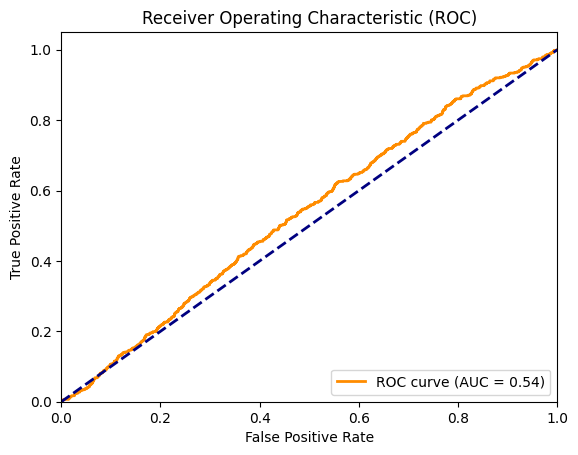

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

y_test = pd_predict["Default"]
y_prob = pd_predict["PredictedDefaultProb"]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC
auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## 7  Hazard Model with GDP Growth Rate of ApprovedFiscalYear

In [25]:
gdp = pd.read_csv("US_GDP_Growth_Rate_1980_2023.csv")
gdp.loc[len(gdp)] = [2024, 0]  # 2024 GDP growth rate not available yet, use 0

In [26]:
df_train_gdp = pd.merge(df_train, gdp, left_on='ApprovalFiscalYear', right_on='Year')
df_test_gdp = pd.merge(df_test, gdp, left_on='ApprovalFiscalYear', right_on='Year')

In [27]:
df_train_gdp["20JobsSupported"] = df_train_gdp["JobsSupported"] >= 20

use_cols = ["GDPGrowthRate", "GrossApproval", "DeliveryMethod", "Subprogram", "TermInMonths", "NaicsCodeBigCategory", "BusinessType", "20JobsSupported","BorrState","Default","SurvivalDays"]
cat_cols = ["DeliveryMethod", "Subprogram", "NaicsCodeBigCategory", "BusinessType","BorrState"]

df_raw = df_train_gdp[use_cols]
for cat in cat_cols:
    dummies = pd.get_dummies(df_train_gdp[cat], prefix = cat)
    df_raw = pd.concat([df_raw, dummies], axis = 1)
    df_raw = df_raw.drop(cat, axis = 1)

In [28]:
cph = CoxPHFitter(penalizer=0.0001)
cph.fit(df_raw, duration_col = 'SurvivalDays', event_col = 'Default', show_progress=True)
cph.print_summary()

C:\Users\caixu\AppData\Local\Programs\Python\Python311\Lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['DeliveryMethod_Direct Loans', 'BorrState_VI'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Iteration 1: norm_delta = 1.49e+00, step_size = 0.9500, log_lik = -125430.57970, newton_decrement = 6.78e+03, seconds_since_start = 1.2
Iteration 2: norm_delta = 4.76e-01, step_size = 0.9500, log_lik = -120820.13295, newton_decrement = 1.16e+03, seconds_since_start = 2.4
Iteration 3: norm_delta = 1.05e-01, step_size = 0.9500, log_lik = -119622.50500, newton_decrement = 3.96e+01, seconds_since_start = 3.6
Iteration 4: norm_delta = 1.92e-02, step_size = 1.0000, log_lik = -119581.19376, newton_decrement = 3.00e-01, seconds_since_start = 4.8
Iteration 5: norm_delta = 1.39e-02, step_size = 1.0000, log_lik = -119580.87591, newton_decrement = 1.97e-02, seconds_since_start = 6.0
Iteration 6: norm_delta = 7.82e-03, step_size = 1.0000, log_lik = -119580.85222, newton_decrement = 3.28e-03, seconds_since_start = 7.3
Iteration 7: norm_delta = 2.17e-03, step_size = 1.0000, log_lik = -119580.84852, newton_decrement = 1.76e-04, seconds_since_start = 8.7
Iteration 8: norm_delta = 1.67e-04, step_size = 

<lifelines.CoxPHFitter: fitted with 101703 total observations, 90213 right-censored observations>
             duration col = 'SurvivalDays'
                event col = 'Default'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 101703
number of events observed = 11490
   partial log-likelihood = -119580.85
         time fit was run = 2025-02-21 00:52:58 UTC

---
                                                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                        
GDPGrowthRate                                                   -0.29      0.75      0.01           -0.30           -0.27                0.74                0.76
GrossApproval                                                    0.00      1.00      0.00            0.00            0.00                1.00                1.00
TermInMonths                                                    -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
20JobsSupported                                                 -0.42      0.66      0.02           -0.46           -0.37                0.63                0.69
DeliveryMethod_504                                              -0.42      0.66      0.42           -1.24            0.41                0.29                1.51
DeliveryMethod_ALP                                               0.11      1.12      0.42           -0.71            0.94                0.49                2.56
DeliveryMethod_Direct Loans                                     -5.66      0.00     22.37          -49.51           38.19                0.00            3.85e+16
DeliveryMethod_PCLP                                              0.89      2.44      0.48           -0.04            1.83                0.96                6.21
Subprogram_Sec. 504 - Delta loans, funded 9/26/95               -0.48      0.62      1.25           -2.93            1.97                0.05                7.17
Subprogram_Sec. 504 - Loan Guarantees - Private Sector Financed  0.32      1.38      0.76           -1.16            1.81                0.31                6.11
Subprogram_Sec. 504 - Premier Certified Lender Program          -0.32      0.72      0.76           -1.81            1.16                0.16                3.20
NaicsCodeBigCategory_0.                                         -0.86      0.42      0.33           -1.51           -0.21                0.22                0.81
NaicsCodeBigCategory_11                                         -0.07      0.93      0.35           -0.76            0.62                0.47                1.86
NaicsCodeBigCategory_21                                          0.16      1.17      0.46           -0.74            1.05                0.48                2.87
NaicsCodeBigCategory_22                                         -0.76      0.47      0.78           -2.28            0.77                0.10                2.15
NaicsCodeBigCategory_23                                          0.46      1.58      0.33           -0.19            1.11                0.83                3.03
NaicsCodeBigCategory_31                                          0.03      1.03      0.34           -0.63            0.69                0.53                2.00
NaicsCodeBigCategory_32                                          0.06      1.06      0.33           -0.59            0.71                0.55                2.03
NaicsCodeBigCategory_33                                         -0.06      0.94      0.33           -0.71            0.59                0.49                1.80
NaicsCodeBigCategory_42                                         -0.34      0.71      0.33           -0.99            0.31                0.37          

In [29]:
df_test_gdp["NaicsCodeBigCategory"] = df_test_gdp["NaicsCode"].apply(lambda x: str(x)[:2])
df_test_gdp["20JobsSupported"] = df_test_gdp["JobsSupported"] >= 20

df_raw_test = df_test_gdp[use_cols]
for cat in cat_cols:
    values_raw = list(df_train_gdp[cat][~df_train_gdp[cat].isna()].unique())
    dummies_test = pd.get_dummies(df_raw_test[cat].astype(pd.CategoricalDtype(categories=values_raw)), prefix = cat)
    df_raw_test = pd.concat([df_raw_test, dummies_test], axis = 1)
    df_raw_test = df_raw_test.drop(cat, axis = 1)

survival = cph.predict_survival_function(df_raw_test, times=((df_raw_test["TermInMonths"]*30).astype(int).unique())).transpose()
survival = survival.rename(lambda x: str(int(x)), axis='columns')
pd_predict = pd.concat([df_raw_test, survival], axis=1)
pd_predict["PredictedDefaultProb"] = pd_predict.apply(lambda row: 1 - row[str(row["TermInMonths"]*30)], axis=1)

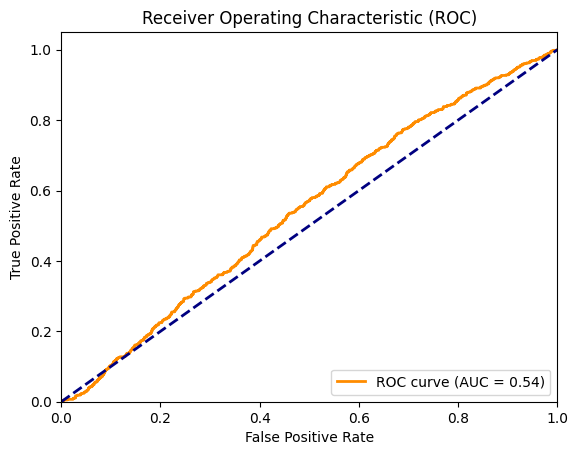

In [30]:
y_test = pd_predict["Default"]
y_prob = pd_predict["PredictedDefaultProb"]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC
auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## 8  Hazard Model with Time-Dependent Intensity

In [31]:
df_train["ID"] = range(len(df_train))
for_process_cols = ["ID","BorrState", "ApprovalFiscalYear", "GrossApproval", "DeliveryMethod", "Subprogram", "TermInMonths", "NaicsCodeBigCategory", "BusinessType", "20JobsSupported","Default","SurvivalDays"]
df_train_to_process = df_train[for_process_cols]

In [32]:
gdp = pd.read_csv("US_GDP_Growth_Rate_1980_2023.csv")
gdp.loc[len(gdp)] = [2024, 0]  # 2024 GDP growth rate not available yet, use 0

sp500 = pd.read_csv("S&P500.csv")

unemployment = pd.read_csv("Unemployment_Rate_1989_2024.csv")

In [33]:
def get_unemployment_rate(year, state):
    tmp = unemployment[(unemployment["Year"]==year)&(unemployment["State"]==state)]
    if len(tmp)>0:
        return float(tmp["Value"].iloc[0])
    else:
        return float(unemployment[unemployment["Year"]==year]["Value"].mean())

WARNING: The code block below takes ~40 minutes. Can skip and directly load the processed data from below.

In [34]:
from tqdm import tqdm

train_df_time = pd.DataFrame()
for i in tqdm(range(len(df_train_to_process))):
    loan = df_train_to_process[df_train_to_process["ID"]==i]
    year = int(loan["ApprovalFiscalYear"].iloc[0])
    survival_days = int(loan["SurvivalDays"].iloc[0])
    full_years = survival_days // 365
    borr_state = str(loan["BorrState"].iloc[0])
    start = 0
    if survival_days % 365 == 0:
        tmp = pd.concat([loan]*(full_years))
        tmp["Start"] = [i*365 for i in list(range(full_years))]
        tmp["End"] = [i*365 for i in list(range(1, full_years+1))]
        tmp["Event"] = [False]*(full_years-1) + [loan["Default"].iloc[0]]
        tmp["CurrentYear"] = range(year, year+full_years)
    else:
        tmp = pd.concat([loan]*(full_years+1))
        tmp["Start"] = [i*365 for i in list(range(full_years+1))]
        tmp["End"] = [i*365 for i in list(range(1, full_years+1))] + [survival_days]
        tmp["Event"] = [False]*full_years + [loan["Default"].iloc[0]]
        tmp["CurrentYear"] = range(year, year+full_years+1)
    train_df_time = pd.concat([train_df_time, tmp])


00%|██████████████████████████████████████████████████████████████████████████| 101703/101703 [43:59<00:00, 38.52it/s]

In [42]:
train_df_time = pd.merge(train_df_time, gdp, left_on="CurrentYear", right_on="Year")
train_df_time = pd.merge(train_df_time, sp500, left_on="CurrentYear", right_on="Year")
train_df_time = pd.merge(train_df_time, unemployment, left_on=["CurrentYear","BorrState"], right_on=["Year","State"])
train_df_time = train_df_time.rename(columns={"Return": "S&P500Return", "Value": "UnemploymentRateByState"})
train_df_time.to_csv("train_df_time_processed.csv", index=False)

LOAD processed data here:

In [34]:
train_df_time = pd.read_csv("train_df_time_processed.csv")
train_df_time["NaicsCodeBigCategory"] = train_df_time["NaicsCodeBigCategory"].astype(int)
train_df_time["DeliveryMethod"] = train_df_time["DeliveryMethod"].astype(str)

C:\Users\caixu\AppData\Local\Temp\ipykernel_11064\3579993959.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df_time = pd.read_csv("train_df_time_processed.csv")


In [35]:
use_cols = ["ID", "Start", "End", "Event", "UnemploymentRateByState", "S&P500Return", "GDPGrowthRate", "GrossApproval", "DeliveryMethod", "Subprogram", "TermInMonths", "NaicsCodeBigCategory", "BusinessType", "20JobsSupported","BorrState"]
cat_cols = ["DeliveryMethod", "Subprogram", "NaicsCodeBigCategory", "BusinessType","BorrState"]

df_train_time_varying = train_df_time[use_cols]
for cat in cat_cols:
    dummies = pd.get_dummies(df_train_time_varying[cat], prefix = cat)
    df_train_time_varying = pd.concat([df_train_time_varying, dummies], axis = 1)
    df_train_time_varying = df_train_time_varying.drop(cat, axis = 1)
if "NaicsCodeBigCategory_0" in df_train_time_varying:
    df_train_time_varying = df_train_time_varying.rename(columns={"NaicsCodeBigCategory_0": "NaicsCodeBigCategory_0."})

### 8.1  Time-Varying as Multi-Period Standard Cox (IN USE)

In [36]:
df_train_slice = df_train_time_varying.copy(deep=True)
df_train_slice["Duration"] = df_train_slice["End"] - df_train_slice["Start"]
df_train_slice = df_train_slice.drop(columns=['ID', 'Start', 'End'])

In [37]:
cph = CoxPHFitter(penalizer=0.0001)
cph.fit(df_train_slice, duration_col = 'Duration', event_col = 'Event', fit_options={"step_size": 0.75}, show_progress=True)
cph.print_summary()

C:\Users\caixu\AppData\Local\Programs\Python\Python311\Lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['DeliveryMethod_Direct Loans'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Iteration 1: norm_delta = 1.31e+00, step_size = 0.7500, log_lik = -158778.94860, newton_decrement = 7.00e+03, seconds_since_start = 1.5
Iteration 2: norm_delta = 2.90e-01, step_size = 0.7500, log_lik = -153304.19792, newton_decrement = 4.70e+02, seconds_since_start = 3.0
Iteration 3: norm_delta = 9.62e-02, step_size = 0.7500, log_lik = -152858.67693, newton_decrement = 3.91e+01, seconds_since_start = 4.8
Iteration 4: norm_delta = 1.53e-02, step_size = 0.9750, log_lik = -152818.74719, newton_decrement = 2.61e-01, seconds_since_start = 6.3
Iteration 5: norm_delta = 4.33e-03, step_size = 1.0000, log_lik = -152818.47351, newton_decrement = 5.33e-03, seconds_since_start = 7.7
Iteration 6: norm_delta = 5.12e-04, step_size = 1.0000, log_lik = -152818.46785, newton_decrement = 5.74e-05, seconds_since_start = 9.2
Iteration 7: norm_delta = 6.21e-06, step_size = 1.0000, log_lik = -152818.46779, newton_decrement = 8.25e-09, seconds_since_start = 10.7
Convergence success after 7 iterations.


<lifelines.CoxPHFitter: fitted with 1.0481e+06 total observations, 1.03661e+06 right-censored observations>
             duration col = 'Duration'
                event col = 'Event'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1.0481e+06
number of events observed = 11490
   partial log-likelihood = -152818.47
         time fit was run = 2025-02-21 00:53:17 UTC

---
                                                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                        
UnemploymentRateByState                                          0.23      1.26      0.00            0.23            0.24                1.25                1.28
S&P500Return                                                     0.01      1.01      0.00            0.01            0.01                1.01                1.01
GDPGrowthRate                                                    0.16      1.17      0.01            0.15            0.17                1.16                1.19
GrossApproval                                                    0.00      1.00      0.00            0.00            0.00                1.00                1.00
TermInMonths                                                    -0.00      1.00      0.00           -0.01           -0.00                0.99                1.00
20JobsSupported                                                 -0.30      0.74      0.02           -0.35           -0.26                0.71                0.77
DeliveryMethod_504                                              -0.37      0.69      0.15           -0.66           -0.08                0.52                0.92
DeliveryMethod_ALP                                               0.11      1.11      0.15           -0.18            0.40                0.83                1.48
DeliveryMethod_Direct Loans                                     -3.20      0.04      6.30          -15.55            9.14                0.00             9291.63
DeliveryMethod_PCLP                                              0.85      2.34      0.21            0.44            1.26                1.55                3.54
Subprogram_Sec. 504 - Delta loans, funded 9/26/95               -0.75      0.47      0.98           -2.67            1.16                0.07                3.19
Subprogram_Sec. 504 - Loan Guarantees - Private Sector Financed  0.27      1.32      0.27           -0.25            0.80                0.78                2.23
Subprogram_Sec. 504 - Premier Certified Lender Program          -0.27      0.76      0.27           -0.80            0.26                0.45                1.29
NaicsCodeBigCategory_0.                                         -0.85      0.43      0.11           -1.06           -0.64                0.35                0.53
NaicsCodeBigCategory_11                                          0.13      1.14      0.17           -0.19            0.46                0.82                1.58
NaicsCodeBigCategory_21                                          0.31      1.36      0.33           -0.34            0.96                0.71                2.61
NaicsCodeBigCategory_22                                         -0.58      0.56      0.70           -1.96            0.80                0.14                2.22
NaicsCodeBigCategory_23                                          0.54      1.71      0.11            0.32            0.75                1.38                2.13
NaicsCodeBigCategory_31                                          0.16      1.18      0.13           -0.09            0.42                0.91                1.52
NaicsCodeBigCategory_32                                          0.22      1.24      0.12           -0.01            0.44                0.99  

In [38]:
def compute_survival(cph, df, times):
    return pd.DataFrame({t: (cph.predict_partial_hazard(df) * cph.baseline_hazard_["baseline hazard"].mean()).apply(lambda x: np.exp(-1*x*t)) for t in times})

In [39]:
df_test_time = pd.merge(df_test, gdp, left_on="ApprovalFiscalYear", right_on="Year")
df_test_time = pd.merge(df_test_time, sp500, left_on="ApprovalFiscalYear", right_on="Year")
df_test_time = pd.merge(df_test_time, unemployment, left_on=["ApprovalFiscalYear","BorrState"], right_on=["Year","State"])
df_test_time = df_test_time.rename(columns={"Return": "S&P500Return", "Value": "UnemploymentRateByState"})

df_test_time["NaicsCodeBigCategory"] = df_test_time["NaicsCode"].apply(lambda x: str(x)[:2])
df_test_time["20JobsSupported"] = df_test_time["JobsSupported"] >= 20

use_cols = ["Default","SurvivalDays", "UnemploymentRateByState", "S&P500Return", "GDPGrowthRate", "GrossApproval", "DeliveryMethod", "Subprogram", "TermInMonths", "NaicsCodeBigCategory", "BusinessType", "20JobsSupported","BorrState"]
cat_cols = ["DeliveryMethod", "Subprogram", "NaicsCodeBigCategory", "BusinessType","BorrState"]

df_raw_test = df_test_time[use_cols]
for cat in cat_cols:
    values_raw = list(train_df_time[cat][~train_df_time[cat].isna()].unique())
    dummies_test = pd.get_dummies(df_raw_test[cat].astype(pd.CategoricalDtype(categories=values_raw)), prefix = cat)
    df_raw_test = pd.concat([df_raw_test, dummies_test], axis = 1)
    df_raw_test = df_raw_test.drop(cat, axis = 1)
    
if "NaicsCodeBigCategory_0" in df_raw_test:
    df_raw_test = df_raw_test.rename(columns={"NaicsCodeBigCategory_0": "NaicsCodeBigCategory_0."})

In [40]:
survival = compute_survival(cph, df_raw_test, list((df_raw_test["TermInMonths"]*30).astype(int).unique()))
survival = survival.rename(lambda x: str(int(x)), axis='columns')
pd_predict = pd.concat([df_raw_test, survival], axis=1)
pd_predict["PredictedDefaultProb"] = pd_predict.apply(lambda row: 1 - row[str(row["TermInMonths"]*30)], axis=1)

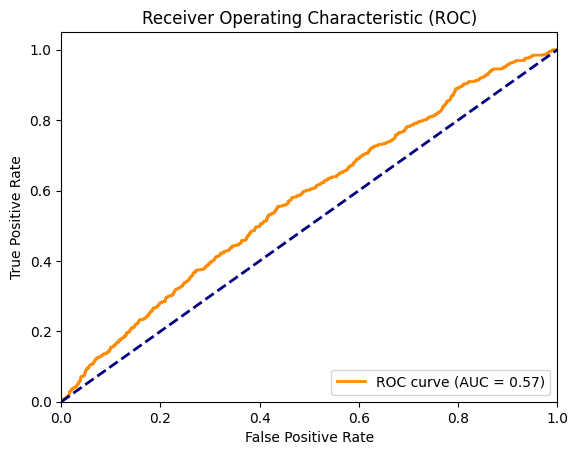

In [41]:
y_test = pd_predict["Default"]
y_prob = pd_predict["PredictedDefaultProb"]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC
auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### 8.2  Time-Varying as Time-Varying Cox (NOT IN USE)

C:\Users\caixu\AppData\Local\Programs\Python\Python311\Lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['DeliveryMethod_Direct Loans'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\caixu\AppData\Local\Programs\Python\Python311\Lib\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column NaicsCodeBigCategory_92 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'NaicsCodeBigCategory_92'].var())
>>> print(df.loc[~events, 'NaicsCodeBigCategory_92'].var())

A very low variance means that the column NaicsCodeBigCategory_92 completely deter

Iteration 1: norm_delta = 1.41e+00, step_size = 0.9500, log_lik = -125427.22023, newton_decrement = 6.62e+03, seconds_since_start = 369.3
Iteration 2: norm_delta = 4.33e-01, step_size = 0.9500, log_lik = -121059.73172, newton_decrement = 1.27e+03, seconds_since_start = 733.5
Iteration 3: norm_delta = 6.71e-02, step_size = 0.9500, log_lik = -119754.61941, newton_decrement = 3.72e+01, seconds_since_start = 1099.7
Iteration 4: norm_delta = 1.65e-02, step_size = 1.0000, log_lik = -119716.32560, newton_decrement = 4.88e-01, seconds_since_start = 1488.3
Iteration 5: norm_delta = 1.15e-02, step_size = 1.0000, log_lik = -119715.82424, newton_decrement = 1.13e-02, seconds_since_start = 1875.4
Iteration 6: norm_delta = 5.79e-03, step_size = 1.0000, log_lik = -119715.81090, newton_decrement = 1.50e-03, seconds_since_start = 2235.8
Iteration 7: norm_delta = 1.10e-03, step_size = 1.0000, log_lik = -119715.80925, newton_decrement = 3.99e-05, seconds_since_start = 2594.7
Iteration 8: norm_delta = 3.2

<lifelines.CoxTimeVaryingFitter: fitted with 1048097 periods, 101676 subjects, 11490 events>
         event col = 'Event'
         penalizer = 1e-05
number of subjects = 101676
 number of periods = 1048097
  number of events = 11490
partial log-likelihood = -119715.81
  time fit was run = 2025-02-15 06:21:18 UTC

---
                                                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                        
UnemploymentRateByState                                          0.15      1.16      0.00            0.14            0.16                1.15                1.18
S&P500Return                                                     0.01      1.01      0.00            0.01            0.01                1.01                1.01
GDPGrowthRate                                                    0.14      1.16      0.01            0.13            0.16                1.14                1.17
GrossApproval                                                    0.00      1.00      0.00            0.00            0.00                1.00                1.00
TermInMonths                                                    -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
20JobsSupported                                                 -0.39      0.68      0.02           -0.43           -0.35                0.65                0.71
DeliveryMethod_504                                              -0.48      0.62      0.46           -1.38            0.41                0.25                1.51
DeliveryMethod_ALP                                               0.06      1.06      0.46           -0.84            0.95                0.43                2.59
DeliveryMethod_Direct Loans                                     -5.07      0.01     16.58          -37.56           27.43                0.00            8.20e+11
DeliveryMethod_PCLP                                              1.32      3.76      0.51            0.33            2.32                1.40               10.14
Subprogram_Sec. 504 - Delta loans, funded 9/26/95               -0.44      0.64      1.28           -2.95            2.07                0.05                7.89
Subprogram_Sec. 504 - Loan Guarantees - Private Sector Financed  0.55      1.73      0.81           -1.04            2.14                0.35                8.49
Subprogram_Sec. 504 - Premier Certified Lender Program          -0.55      0.58      0.81           -2.14            1.04                0.12                2.84
NaicsCodeBigCategory_0.                                         -0.88      0.41      0.33           -1.53           -0.23                0.22                0.80
NaicsCodeBigCategory_11                                          0.06      1.06      0.36           -0.64            0.76                0.53                2.14
NaicsCodeBigCategory_21                                          0.30      1.34      0.46           -0.60            1.19                0.55                3.30
NaicsCodeBigCategory_22                                         -0.64      0.53      0.78           -2.16            0.89                0.11                2.44
NaicsCodeBigCategory_23                                          0.57      1.78      0.33           -0.08            1.23                0.92                3.42
NaicsCodeBigCategory_31                                          0.17      1.18      0.34           -0.50            0.84                0.61                2.31
NaicsCodeBigCategory_32                                          0.19      1.21      0.34           -0.46            0.85                0.63                2.34
NaicsCodeBigCategory_33                                          0.08      1.08      0.33           -0.58            

<Axes: xlabel='log(HR) (95% CI)'>

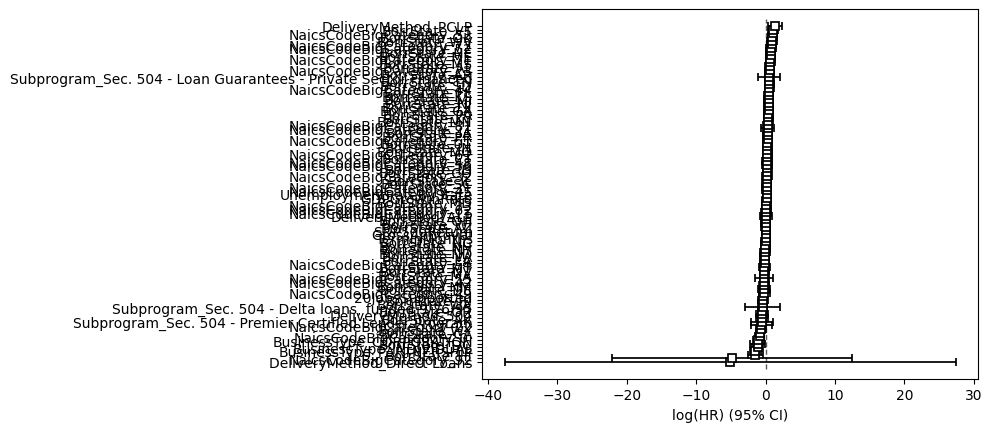

In [37]:
from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter(penalizer=0.00001)
ctv.fit(df_train_time_varying, id_col="ID", event_col="Event", start_col="Start", stop_col="End", show_progress=True)
ctv.print_summary()
ctv.plot()

In [38]:
import pickle

with open('time_varying_model.pkl', 'wb') as f:
    pickle.dump(ctv, f)

In [39]:
df_test_time = pd.merge(df_test, gdp, left_on="ApprovalFiscalYear", right_on="Year")
df_test_time = pd.merge(df_test_time, sp500, left_on="ApprovalFiscalYear", right_on="Year")
df_test_time = pd.merge(df_test_time, unemployment, left_on=["ApprovalFiscalYear","BorrState"], right_on=["Year","State"])
df_test_time = df_test_time.rename(columns={"Return": "S&P500Return", "Value": "UnemploymentRateByState"})

df_test_time["NaicsCodeBigCategory"] = df_test_time["NaicsCode"].apply(lambda x: str(x)[:2])
df_test_time["20JobsSupported"] = df_test_time["JobsSupported"] >= 20

use_cols = ["Default","SurvivalDays", "UnemploymentRateByState", "S&P500Return", "GDPGrowthRate", "GrossApproval", "DeliveryMethod", "Subprogram", "TermInMonths", "NaicsCodeBigCategory", "BusinessType", "20JobsSupported","BorrState"]
cat_cols = ["DeliveryMethod", "Subprogram", "NaicsCodeBigCategory", "BusinessType","BorrState"]

df_raw_test = df_test_time[use_cols]
for cat in cat_cols:
    values_raw = list(train_df_time[cat][~train_df_time[cat].isna()].unique())
    dummies_test = pd.get_dummies(df_raw_test[cat].astype(pd.CategoricalDtype(categories=values_raw)), prefix = cat)
    df_raw_test = pd.concat([df_raw_test, dummies_test], axis = 1)
    df_raw_test = df_raw_test.drop(cat, axis = 1)
    
if "NaicsCodeBigCategory_0" in df_raw_test:
    df_raw_test = df_raw_test.rename(columns={"NaicsCodeBigCategory_0": "NaicsCodeBigCategory_0."})
# #f = CoxPHFitter.__dict__["predict_survival_function"]

# survival = ctv.predict_survival_function(df_raw_test, times=((df_raw_test["TermInMonths"]*30).astype(int).unique())).transpose()
# survival = survival.rename(lambda x: str(int(x)), axis='columns')
# pd_predict = pd.concat([df_raw_test, survival], axis=1)
# pd_predict["PredictedDefaultProb"] = pd_predict.apply(lambda row: 1 - row[str(row["TermInMonths"]*30)], axis=1)

In [40]:
from lifelines.fitters.coxph_fitter import SemiParametricPHFitter

In [41]:
import numpy as np

# Set method
f = SemiParametricPHFitter.__dict__["predict_cumulative_hazard"]

# Make predictions
cum_hazard_preds = f(ctv, df_raw_test, times=((df_raw_test["TermInMonths"]*30).astype(int).unique()))
survival_preds = np.exp(-1 * cum_hazard_preds)

In [42]:
survival = survival_preds.transpose()
survival = survival.rename(lambda x: str(int(x)), axis='columns')
pd_predict = pd.concat([df_raw_test, survival], axis=1)
pd_predict["PredictedDefaultProb"] = pd_predict.apply(lambda row: 1 - row[str(row["TermInMonths"]*30)], axis=1)

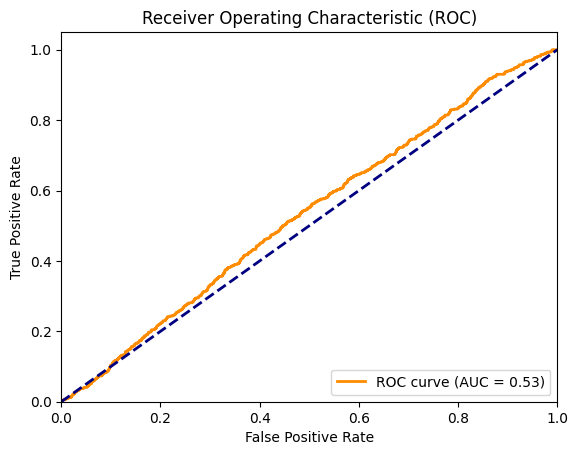

In [44]:
y_test = pd_predict["Default"]
y_prob = pd_predict["PredictedDefaultProb"]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC
auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## 9  Loss at Default Model

In [42]:
df_train_loss = pd.merge(df_train, gdp, left_on="ApprovalFiscalYear", right_on="Year")
df_train_loss = pd.merge(df_train_loss, sp500, left_on="ApprovalFiscalYear", right_on="Year")
df_train_loss = pd.merge(df_train_loss, unemployment, left_on=["ApprovalFiscalYear","BorrState"], right_on=["Year","State"])
df_train_loss = df_train_loss.rename(columns={"Return": "S&P500Return", "Value": "UnemploymentRateByState"})

In [43]:
df_train_loss["LossPortion"] = df_train_loss["LossAtDefault"] / df_train_loss["GrossApproval"]
df_train_loss = df_train_loss[df_train_loss["LossPortion"]<=1]

In [44]:
# Only train on defaulted loans
df_train_loss = df_train_loss[df_train_loss["Default"]==True]

use_cols = ["LossPortion", "UnemploymentRateByState", "S&P500Return", "GDPGrowthRate", "GrossApproval", "DeliveryMethod", "Subprogram", "TermInMonths", "NaicsCodeBigCategory", "BusinessType", "20JobsSupported","BorrState"]
cat_cols = ["DeliveryMethod", "Subprogram", "NaicsCodeBigCategory", "BusinessType","BorrState"]

df_train_loss_raw = df_train_loss[use_cols]
for cat in cat_cols:
    dummies = pd.get_dummies(df_train_loss_raw[cat], prefix = cat)
    df_train_loss_raw = pd.concat([df_train_loss_raw, dummies], axis = 1)
    df_train_loss_raw = df_train_loss_raw.drop(cat, axis = 1)

In [45]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

y_train = np.array(df_train_loss_raw["LossPortion"], dtype=float).reshape(-1, 1)
X_train = np.array(df_train_loss_raw.drop(columns=["LossPortion"]), dtype=float)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

In [46]:
model = nn.Sequential(
    nn.BatchNorm1d(X_train.shape[1]),
    nn.Linear(X_train.shape[1], 256),
    nn.LeakyReLU(),
    nn.Linear(256, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.9)

In [47]:
# training parameters
n_epochs = 300   # number of epochs to run
batch_size = 2048
n_batch = X_train.shape[0]//batch_size + 1
 
model.train()
 
# training loop
for epoch in range(n_epochs):
    epoch_loss = 0
    for batch in range(n_batch):
        st = batch * batch_size
        ed = min(X_train.shape[0], (batch + 1) * batch_size)
        optimizer.zero_grad()
        y = model(X_train[st:ed])
        loss = torch.mean(torch.square(y - y_train[st:ed]))
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss
    epoch_loss /= n_batch
    print("Epoch:", epoch, "Loss:", epoch_loss)

Epoch: 0 Loss: tensor(0.0903, grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(0.0636, grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(0.0645, grad_fn=<DivBackward0>)
Epoch: 3 Loss: tensor(0.0596, grad_fn=<DivBackward0>)
Epoch: 4 Loss: tensor(0.0568, grad_fn=<DivBackward0>)
Epoch: 5 Loss: tensor(0.0577, grad_fn=<DivBackward0>)
Epoch: 6 Loss: tensor(0.0568, grad_fn=<DivBackward0>)
Epoch: 7 Loss: tensor(0.0554, grad_fn=<DivBackward0>)
Epoch: 8 Loss: tensor(0.0554, grad_fn=<DivBackward0>)
Epoch: 9 Loss: tensor(0.0554, grad_fn=<DivBackward0>)
Epoch: 10 Loss: tensor(0.0548, grad_fn=<DivBackward0>)
Epoch: 11 Loss: tensor(0.0544, grad_fn=<DivBackward0>)
Epoch: 12 Loss: tensor(0.0543, grad_fn=<DivBackward0>)
Epoch: 13 Loss: tensor(0.0541, grad_fn=<DivBackward0>)
Epoch: 14 Loss: tensor(0.0538, grad_fn=<DivBackward0>)
Epoch: 15 Loss: tensor(0.0536, grad_fn=<DivBackward0>)
Epoch: 16 Loss: tensor(0.0535, grad_fn=<DivBackward0>)
Epoch: 17 Loss: tensor(0.0533, grad_fn=<DivBackward0>)
Epoch: 18 Loss: tens

In [48]:
df_test_loss = pd.merge(df_test, gdp, left_on="ApprovalFiscalYear", right_on="Year")
df_test_loss = pd.merge(df_test_loss, sp500, left_on="ApprovalFiscalYear", right_on="Year")
df_test_loss = pd.merge(df_test_loss, unemployment, left_on=["ApprovalFiscalYear","BorrState"], right_on=["Year","State"])
df_test_loss = df_test_loss.rename(columns={"Return": "S&P500Return", "Value": "UnemploymentRateByState"})

df_test_loss["LossPortion"] = df_test_loss["LossAtDefault"] / df_test_loss["GrossApproval"]
df_test_loss = df_test_loss[df_test_loss["LossPortion"]<=1]

# Only test on defaulted loans
df_test_loss = df_test_loss[df_test_loss["Default"]==True]

df_test_loss["NaicsCodeBigCategory"] = df_test_loss["NaicsCode"].apply(lambda x: str(x)[:2])
df_test_loss["20JobsSupported"] = df_test_loss["JobsSupported"] >= 20

use_cols = ["LossPortion", "UnemploymentRateByState", "S&P500Return", "GDPGrowthRate", "GrossApproval", "DeliveryMethod", "Subprogram", "TermInMonths", "NaicsCodeBigCategory", "BusinessType", "20JobsSupported","BorrState"]
cat_cols = ["DeliveryMethod", "Subprogram", "NaicsCodeBigCategory", "BusinessType","BorrState"]

df_raw_test = df_test_loss[use_cols]
for cat in cat_cols:
    values_raw = list(df_train_loss[cat][~df_train_loss[cat].isna()].unique())
    dummies_test = pd.get_dummies(df_raw_test[cat].astype(pd.CategoricalDtype(categories=values_raw)), prefix = cat)
    df_raw_test = pd.concat([df_raw_test, dummies_test], axis = 1)
    df_raw_test = df_raw_test.drop(cat, axis = 1)

In [49]:
y_test = np.array(df_raw_test["LossPortion"], dtype=float).reshape(-1, 1)
X_test = np.array(df_raw_test.drop(columns=["LossPortion"]), dtype=float)
X_test = torch.tensor(X_test, dtype=torch.float32)

In [50]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

model.eval()
y_pred = model(X_test).detach().numpy()

rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred) 
 
print("RMSE:",rmse)
print("MAE:",mae)

RMSE: 0.3491968183876234
MAE: 0.24887084490835162


## 10  Estimating Portfolio Loss with Monte Carlo Simulation

Construct a portfolio of 1000 loans, with approval date between 2011-01-01 and 2012-01-01. Evaluate this portfolio in the year 2013, for five year period and 10 year period.

In [93]:
import random
ST = "2011-01-01"
ED = "2012-01-01"
EVAL_YEAR = 2013

NO_TRIALS = 10000

df_range = df_test[(df_test["ApprovalDate"]>=ST) & (df_test["ApprovalDate"]<=ED)]
portfolio_indices = random.sample(range(len(df_range)), 1000)
df_portfolio = df_range.iloc[portfolio_indices].reset_index(drop=True)

In [94]:
df_portfolio["CurrentYear"] = [EVAL_YEAR]*len(df_portfolio)

### 10.1  5-Year Period

In [95]:
# First predict default or not
df_portfolio_time = pd.merge(df_portfolio, gdp, left_on="CurrentYear", right_on="Year")
df_portfolio_time = pd.merge(df_portfolio_time, sp500, left_on="CurrentYear", right_on="Year")
df_portfolio_time = pd.merge(df_portfolio_time, unemployment, left_on=["CurrentYear","BorrState"], right_on=["Year","State"])
df_portfolio_time = df_portfolio_time.rename(columns={"Return": "S&P500Return", "Value": "UnemploymentRateByState"})

df_portfolio_time["NaicsCodeBigCategory"] = df_portfolio_time["NaicsCode"].apply(lambda x: str(x)[:2])
df_portfolio_time["20JobsSupported"] = df_portfolio_time["JobsSupported"] >= 20

use_cols = ["UnemploymentRateByState", "S&P500Return", "GDPGrowthRate", "GrossApproval", "DeliveryMethod", "Subprogram", "TermInMonths", "NaicsCodeBigCategory", "BusinessType", "20JobsSupported","BorrState"]
cat_cols = ["DeliveryMethod", "Subprogram", "NaicsCodeBigCategory", "BusinessType","BorrState"]

df_raw_test = df_portfolio_time[use_cols]
for cat in cat_cols:
    values_raw = list(train_df_time[cat][~train_df_time[cat].isna()].unique())
    dummies_test = pd.get_dummies(df_raw_test[cat].astype(pd.CategoricalDtype(categories=values_raw)), prefix = cat)
    df_raw_test = pd.concat([df_raw_test, dummies_test], axis = 1)
    df_raw_test = df_raw_test.drop(cat, axis = 1)
    
if "NaicsCodeBigCategory_0" in df_raw_test:
    df_raw_test = df_raw_test.rename(columns={"NaicsCodeBigCategory_0": "NaicsCodeBigCategory_0."})

df_raw_test["Period"] = df_raw_test["TermInMonths"].apply(lambda x: min(x,12*5))

survival = compute_survival(cph, df_raw_test, list((df_raw_test["Period"]*30).astype(int).unique()))
survival = survival.rename(lambda x: str(int(x)), axis='columns')
pd_predict = pd.concat([df_raw_test, survival], axis=1)
pd_predict["PredictedDefaultProb"] = pd_predict.apply(lambda row: 1 - row[str(row["Period"]*30)], axis=1)

# Then predict loss at default
use_cols = ["UnemploymentRateByState", "S&P500Return", "GDPGrowthRate", "GrossApproval", "DeliveryMethod", "Subprogram", "TermInMonths", "NaicsCodeBigCategory", "BusinessType", "20JobsSupported","BorrState"]
cat_cols = ["DeliveryMethod", "Subprogram", "NaicsCodeBigCategory", "BusinessType","BorrState"]

df_raw_test = df_portfolio_time[use_cols]
for cat in cat_cols:
    values_raw = list(df_train_loss[cat][~df_train_loss[cat].isna()].unique())
    dummies_test = pd.get_dummies(df_raw_test[cat].astype(pd.CategoricalDtype(categories=values_raw)), prefix = cat)
    df_raw_test = pd.concat([df_raw_test, dummies_test], axis = 1)
    df_raw_test = df_raw_test.drop(cat, axis = 1)

X_test = np.array(df_raw_test, dtype=float)
X_test = torch.tensor(X_test, dtype=torch.float32)

model.eval()
y_pred = model(X_test).detach().numpy()

pd_predict["PredictedLossAtDefault"] = y_pred.squeeze() * np.array(pd_predict["GrossApproval"])

In [96]:
from tqdm import tqdm
# Monte Carlo simulation to sample default scenarios
loss_list_5_year = []
for trial in tqdm(range(NO_TRIALS)):
    pd_predict["Random"] = list(np.random.rand(len(pd_predict)))
    df_default = pd_predict[pd_predict["Random"] <= pd_predict["PredictedDefaultProb"]]
    loss_list_5_year.append(float(df_default["PredictedLossAtDefault"].sum()))


00%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1092.97it/s]

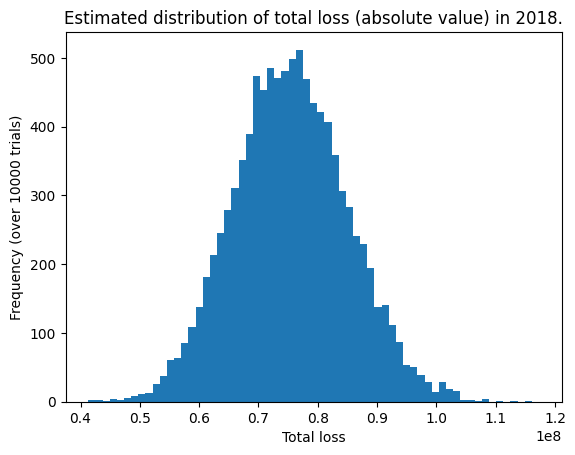

In [97]:
# Calculate the IQR
IQR = np.percentile(loss_list_5_year, 75) - np.percentile(loss_list_5_year, 25)

# Calculate the bin width using the Freedman-Diaconis rule
bin_width_fd = 2 * IQR / np.power(len(loss_list_5_year), 1/3)

plt.hist(loss_list_5_year, bins=np.arange(min(loss_list_5_year), max(loss_list_5_year), bin_width_fd))
plt.title("Estimated distribution of total loss (absolute value) in 2018.")
plt.xlabel("Total loss")
plt.ylabel("Frequency (over "+str(NO_TRIALS)+" trials)")
plt.show() 

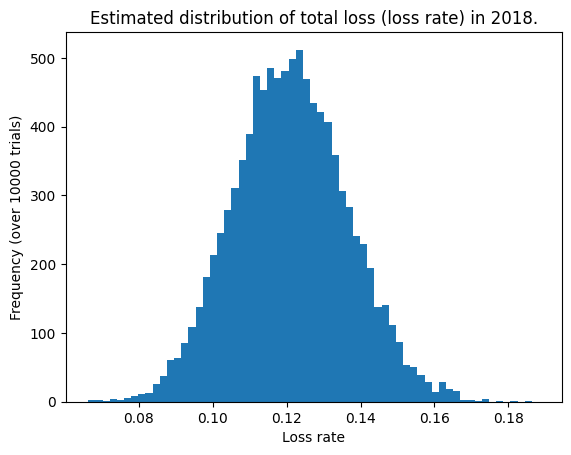

In [120]:
portfolio_value = df_portfolio["GrossApproval"].sum()
loss_list_5_year_percent = [i/portfolio_value for i in loss_list_5_year]

# Calculate the IQR
IQR = np.percentile(loss_list_5_year_percent, 75) - np.percentile(loss_list_5_year_percent, 25)

# Calculate the bin width using the Freedman-Diaconis rule
bin_width_fd = 2 * IQR / np.power(len(loss_list_5_year_percent), 1/3)

plt.hist(loss_list_5_year_percent, bins=np.arange(min(loss_list_5_year_percent), max(loss_list_5_year_percent), bin_width_fd))
plt.title("Estimated distribution of total loss (loss rate) in 2018.")
plt.xlabel("Loss rate")
plt.ylabel("Frequency (over "+str(NO_TRIALS)+" trials)")
plt.show() 

### 10.2  10-Year Period

In [99]:
# First predict default or not
df_portfolio_time = pd.merge(df_portfolio, gdp, left_on="CurrentYear", right_on="Year")
df_portfolio_time = pd.merge(df_portfolio_time, sp500, left_on="CurrentYear", right_on="Year")
df_portfolio_time = pd.merge(df_portfolio_time, unemployment, left_on=["CurrentYear","BorrState"], right_on=["Year","State"])
df_portfolio_time = df_portfolio_time.rename(columns={"Return": "S&P500Return", "Value": "UnemploymentRateByState"})

df_portfolio_time["NaicsCodeBigCategory"] = df_portfolio_time["NaicsCode"].apply(lambda x: str(x)[:2])
df_portfolio_time["20JobsSupported"] = df_portfolio_time["JobsSupported"] >= 20

use_cols = ["UnemploymentRateByState", "S&P500Return", "GDPGrowthRate", "GrossApproval", "DeliveryMethod", "Subprogram", "TermInMonths", "NaicsCodeBigCategory", "BusinessType", "20JobsSupported","BorrState"]
cat_cols = ["DeliveryMethod", "Subprogram", "NaicsCodeBigCategory", "BusinessType","BorrState"]

df_raw_test = df_portfolio_time[use_cols]
for cat in cat_cols:
    values_raw = list(train_df_time[cat][~train_df_time[cat].isna()].unique())
    dummies_test = pd.get_dummies(df_raw_test[cat].astype(pd.CategoricalDtype(categories=values_raw)), prefix = cat)
    df_raw_test = pd.concat([df_raw_test, dummies_test], axis = 1)
    df_raw_test = df_raw_test.drop(cat, axis = 1)
    
if "NaicsCodeBigCategory_0" in df_raw_test:
    df_raw_test = df_raw_test.rename(columns={"NaicsCodeBigCategory_0": "NaicsCodeBigCategory_0."})

df_raw_test["Period"] = df_raw_test["TermInMonths"].apply(lambda x: min(x,12*10))

survival = compute_survival(cph, df_raw_test, list((df_raw_test["Period"]*30).astype(int).unique()))
survival = survival.rename(lambda x: str(int(x)), axis='columns')
pd_predict = pd.concat([df_raw_test, survival], axis=1)
pd_predict["PredictedDefaultProb"] = pd_predict.apply(lambda row: 1 - row[str(row["Period"]*30)], axis=1)

# Then predict loss at default
use_cols = ["UnemploymentRateByState", "S&P500Return", "GDPGrowthRate", "GrossApproval", "DeliveryMethod", "Subprogram", "TermInMonths", "NaicsCodeBigCategory", "BusinessType", "20JobsSupported","BorrState"]
cat_cols = ["DeliveryMethod", "Subprogram", "NaicsCodeBigCategory", "BusinessType","BorrState"]

df_raw_test = df_portfolio_time[use_cols]
for cat in cat_cols:
    values_raw = list(df_train_loss[cat][~df_train_loss[cat].isna()].unique())
    dummies_test = pd.get_dummies(df_raw_test[cat].astype(pd.CategoricalDtype(categories=values_raw)), prefix = cat)
    df_raw_test = pd.concat([df_raw_test, dummies_test], axis = 1)
    df_raw_test = df_raw_test.drop(cat, axis = 1)

X_test = np.array(df_raw_test, dtype=float)
X_test = torch.tensor(X_test, dtype=torch.float32)

model.eval()
y_pred = model(X_test).detach().numpy()

pd_predict["PredictedLossAtDefault"] = y_pred.squeeze() * np.array(pd_predict["GrossApproval"])

In [100]:
from tqdm import tqdm
# Monte Carlo simulation to sample default scenarios
loss_list_10_year = []
for trial in tqdm(range(NO_TRIALS)):
    pd_predict["Random"] = list(np.random.rand(len(pd_predict)))
    df_default = pd_predict[pd_predict["Random"] <= pd_predict["PredictedDefaultProb"]]
    loss_list_10_year.append(float(df_default["PredictedLossAtDefault"].sum()))


00%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1145.29it/s]

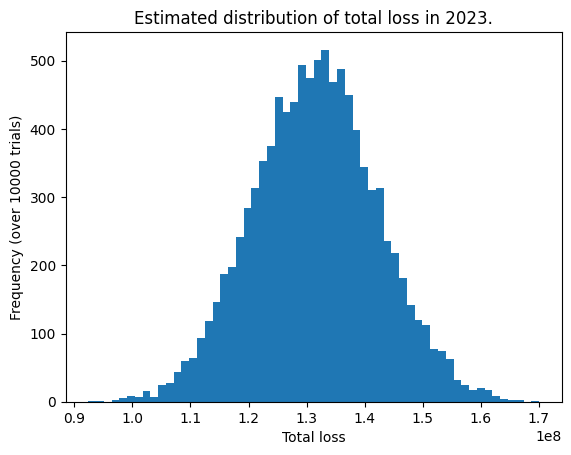

In [122]:
# Calculate the IQR
IQR = np.percentile(loss_list_10_year, 75) - np.percentile(loss_list_10_year, 25)

# Calculate the bin width using the Freedman-Diaconis rule
bin_width_fd = 2 * IQR / np.power(len(loss_list_10_year), 1/3)

plt.hist(loss_list_10_year, bins=np.arange(min(loss_list_10_year), max(loss_list_10_year), bin_width_fd))
plt.title("Estimated distribution of total loss in 2023.")
plt.xlabel("Total loss")
plt.ylabel("Frequency (over "+str(NO_TRIALS)+" trials)")
plt.show() 

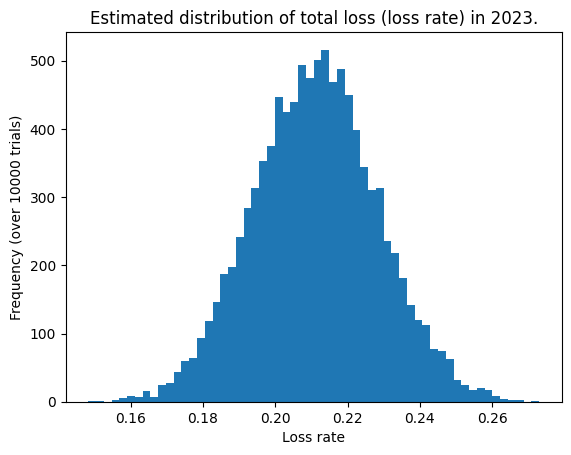

In [123]:
loss_list_10_year_percent = [i/portfolio_value for i in loss_list_10_year]

# Calculate the IQR
IQR = np.percentile(loss_list_10_year_percent, 75) - np.percentile(loss_list_10_year_percent, 25)

# Calculate the bin width using the Freedman-Diaconis rule
bin_width_fd = 2 * IQR / np.power(len(loss_list_10_year_percent), 1/3)

plt.hist(loss_list_10_year_percent, bins=np.arange(min(loss_list_10_year_percent), max(loss_list_10_year_percent), bin_width_fd))
plt.title("Estimated distribution of total loss (loss rate) in 2023.")
plt.xlabel("Loss rate")
plt.ylabel("Frequency (over "+str(NO_TRIALS)+" trials)")
plt.show() 

## 11  Value At Risk

Bootstrap from the simulation results above to get VaR with confidence intervals.

In [103]:
VAR_PS = [0.95, 0.99]
N_TRIALS = 1000
CONFIDENCE_LEVELS = [0.75, 0.9, 0.95]

### 11.1  5-Year Period

In [104]:
for VAR_P in VAR_PS:
    var_5_year_list = []
    for trial in tqdm(range(N_TRIALS)):
        sample = np.random.choice(loss_list_5_year, size=len(loss_list_5_year), replace=True)
        var_5_year_list.append(sorted(sample)[int(len(sample)*VAR_P)])
    var_5_year_list_sorted = sorted(var_5_year_list)
    median = var_5_year_list_sorted[int(len(var_5_year_list_sorted)*0.5)]
    print("Estimated "+str(int(VAR_P*100))+"% VaR: " +str(median) +" (absolute); "+str(median/portfolio_value)+" (loss rate)")
    for CONFIDENCE_LEVEL in CONFIDENCE_LEVELS:
        lower, upper = var_5_year_list_sorted[int(len(var_5_year_list_sorted)*(1-CONFIDENCE_LEVEL))], var_5_year_list_sorted[int(len(var_5_year_list_sorted)*CONFIDENCE_LEVEL)]
        lower_rate, upper_rate = lower/portfolio_value, upper/portfolio_value
        print(str(int(CONFIDENCE_LEVEL*100)) + "% confidence interval for "+str(int(VAR_P*100))+"% VaR: [" + str(lower)+", "+str(upper)+"] (absolute); ["+str(lower_rate)+", "+str(upper_rate)+"] (loss rate)")


00%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.03it/s]

Estimated 95% VaR: 91615598.66699576 (absolute); 0.14705411932950208 (loss rate)
75% confidence interval for 95% VaR: [91469402.08119154, 91751767.06391573] (absolute); [0.1468194561227204, 0.1472726860799346] (loss rate)
90% confidence interval for 95% VaR: [91357228.79177332, 91863690.52690268] (absolute); [0.1466394044227075, 0.14745233677830177] (loss rate)
95% confidence interval for 95% VaR: [91307336.7228806, 91942957.51613379] (absolute); [0.1465593216162936, 0.147579569885577] (loss rate)


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 187.79it/s]

Estimated 99% VaR: 98766313.25724721 (absolute); 0.1585318813257773 (loss rate)
75% confidence interval for 99% VaR: [98480287.56314516, 99015891.84445143] (absolute); [0.1580727754839362, 0.15893248515175043] (loss rate)
90% confidence interval for 99% VaR: [98337197.6018548, 99414212.45104074] (absolute); [0.1578430987853324, 0.15957183791334392] (loss rate)
95% confidence interval for 99% VaR: [98079530.36296368, 99939959.09062028] (absolute); [0.15742951169485314, 0.16041572487362926] (loss rate)


### 11.2  10-Year Period

In [105]:
for VAR_P in VAR_PS:
    var_10_year_list = []
    for trial in tqdm(range(N_TRIALS)):
        sample = np.random.choice(loss_list_10_year, size=len(loss_list_10_year), replace=True)
        var_10_year_list.append(sorted(sample)[int(len(sample)*VAR_P)])
    var_10_year_list_sorted = sorted(var_10_year_list)
    median = var_10_year_list_sorted[int(len(var_10_year_list_sorted)*0.10)]
    print("Estimated "+str(int(VAR_P*100))+"% VaR: " +str(median) +" (absolute); "+str(median/portfolio_value)+" (loss rate)")
    for CONFIDENCE_LEVEL in CONFIDENCE_LEVELS:
        lower, upper = var_10_year_list_sorted[int(len(var_10_year_list_sorted)*(1-CONFIDENCE_LEVEL))], var_10_year_list_sorted[int(len(var_10_year_list_sorted)*CONFIDENCE_LEVEL)]
        lower_rate, upper_rate = lower/portfolio_value, upper/portfolio_value
        print(str(int(CONFIDENCE_LEVEL*100)) + "% confidence interval for "+str(int(VAR_P*100))+"% VaR: [" + str(lower)+", "+str(upper)+"] (absolute); ["+str(lower_rate)+", "+str(upper_rate)+"] (loss rate)")


00%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 187.03it/s]

Estimated 95% VaR: 149185421.2295711 (absolute); 0.23946064922259352 (loss rate)
75% confidence interval for 95% VaR: [149338887.47748733, 149631292.1370864] (absolute); [0.2397069811165339, 0.240176325969712] (loss rate)
90% confidence interval for 95% VaR: [149185421.2295711, 149798895.63256502] (absolute); [0.23946064922259352, 0.24044534985628552] (loss rate)
95% confidence interval for 95% VaR: [149105261.26265526, 149891502.2854209] (absolute); [0.23933198277810366, 0.2405939947374839] (loss rate)


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.46it/s]

Estimated 99% VaR: 156098453.79960537 (absolute); 0.25055690282213233 (loss rate)
75% confidence interval for 99% VaR: [156292391.56520367, 156838256.275028] (absolute); [0.2508681963981144, 0.2517443752949859] (loss rate)
90% confidence interval for 99% VaR: [155997635.14995575, 157051849.75087643] (absolute); [0.2503950766926093, 0.2520872186638274] (loss rate)
95% confidence interval for 99% VaR: [155829628.73107195, 157072221.47473693] (absolute); [0.2501254060652256, 0.25211991774515324] (loss rate)


### 12  Tranche Loss

### 12.1 [5%, 15%] Tranche

In [143]:
LEFT = 0.05
RIGHT = 0.15
loss_rate_5_year = [min(max((i - LEFT),0) / (RIGHT-LEFT), 1) for i in loss_list_5_year_percent]
loss_rate_10_year = [min(max((i - LEFT),0) / (RIGHT-LEFT), 1) for i in loss_list_10_year_percent]

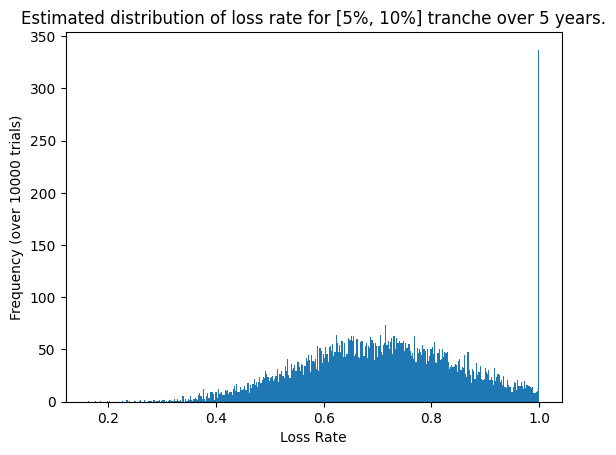

In [144]:
IQR_5_year = np.percentile(loss_rate_5_year, 75) - np.percentile(loss_rate_5_year, 25)
bin_width_fd_5_year = 2 * IQR / np.power(len(loss_rate_5_year), 1/3)
n_bins_5_year = int((max(loss_rate_5_year) - min(loss_rate_5_year))/ bin_width_fd_5_year) + 1

plt.hist(loss_rate_5_year, bins=n_bins_5_year)
plt.title("Estimated distribution of loss rate for [5%, 10%] tranche over 5 years.")
plt.xlabel("Loss Rate")
plt.ylabel("Frequency (over "+str(NO_TRIALS)+" trials)")
plt.show()

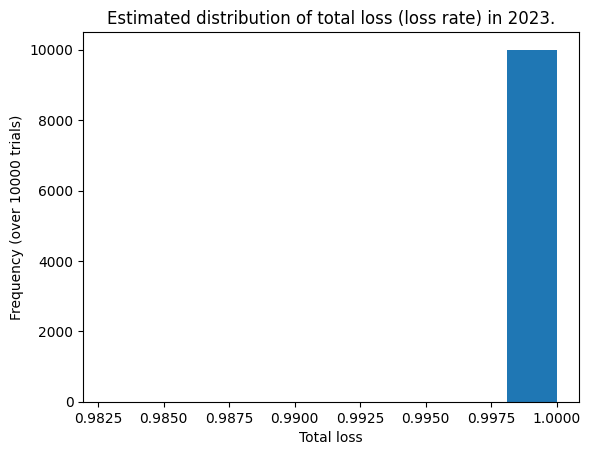

In [145]:
IQR_10_year = np.percentile(loss_rate_10_year, 75) - np.percentile(loss_rate_10_year, 25)
bin_width_fd_10_year = 2 * IQR / np.power(len(loss_rate_10_year), 1/3)
n_bins_10_year = int((max(loss_rate_10_year) - min(loss_rate_10_year))/ bin_width_fd_10_year) + 1

plt.hist(loss_rate_10_year, bins=n_bins_10_year)
plt.title("Estimated distribution of total loss (loss rate) in 2023.")
plt.xlabel("Total loss")
plt.ylabel("Frequency (over "+str(NO_TRIALS)+" trials)")
plt.show()

### 12.2 [15%, 100%] Senior Tranche

In [146]:
LEFT = 0.15
RIGHT = 1
loss_rate_5_year = [min(max((i - LEFT),0) / (RIGHT-LEFT), 1) for i in loss_list_5_year_percent]
loss_rate_10_year = [min(max((i - LEFT),0) / (RIGHT-LEFT), 1) for i in loss_list_10_year_percent]

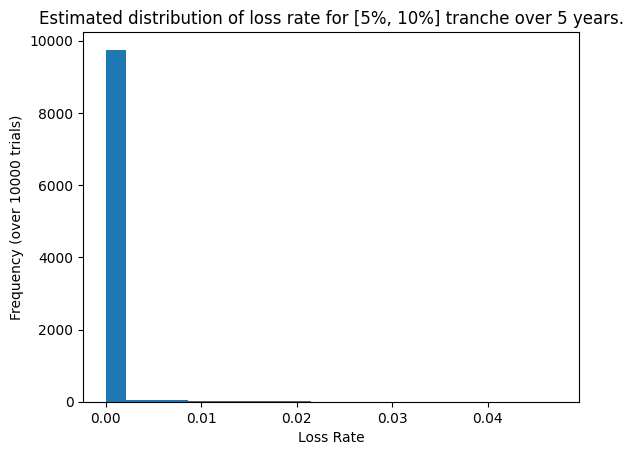

In [147]:
IQR_5_year = np.percentile(loss_rate_5_year, 75) - np.percentile(loss_rate_5_year, 25)
bin_width_fd_5_year = 2 * IQR / np.power(len(loss_rate_5_year), 1/3)
n_bins_5_year = int((max(loss_rate_5_year) - min(loss_rate_5_year))/ bin_width_fd_5_year) + 1

plt.hist(loss_rate_5_year, bins=n_bins_5_year)
plt.title("Estimated distribution of loss rate for [5%, 10%] tranche over 5 years.")
plt.xlabel("Loss Rate")
plt.ylabel("Frequency (over "+str(NO_TRIALS)+" trials)")
plt.show()

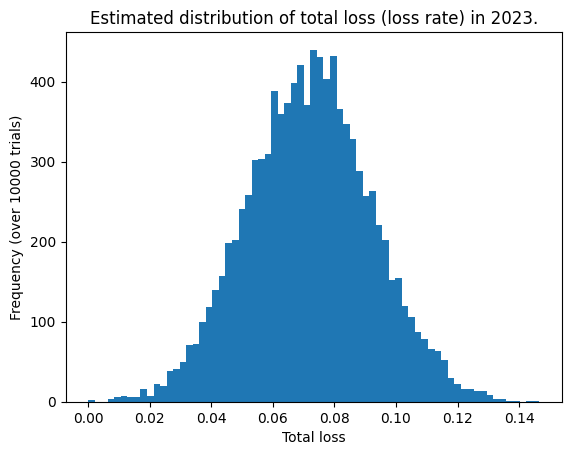

In [148]:
IQR_10_year = np.percentile(loss_rate_10_year, 75) - np.percentile(loss_rate_10_year, 25)
bin_width_fd_10_year = 2 * IQR / np.power(len(loss_rate_10_year), 1/3)
n_bins_10_year = int((max(loss_rate_10_year) - min(loss_rate_10_year))/ bin_width_fd_10_year) + 1

plt.hist(loss_rate_10_year, bins=n_bins_10_year)
plt.title("Estimated distribution of total loss (loss rate) in 2023.")
plt.xlabel("Total loss")
plt.ylabel("Frequency (over "+str(NO_TRIALS)+" trials)")
plt.show()